<h2>프로젝트: 한국어 데이터로 챗봇 만들기</h2>

<h3>프로젝트 목표</h3>

1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다

<h2>01.데이터 다운로드</h2>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
file_path = 'transformer_chatbot/data/ChatbotData .csv'
file_path

'transformer_chatbot/data/ChatbotData .csv'

In [4]:
data = pd.read_csv(file_path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
len(data)

11823

<h3>결측치 확인</h3>

In [6]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [7]:
print(data['Q'][0])
print(data['A'][0])

12시 땡!
하루가 또 가네요.


<h2>02.데이터 전처리</h2>

In [8]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) 
  #첫번째 인자는 찾고자 하는 패턴을 나타내며, 두번째 인자는 대체하고자 하는 문자열, 세 번째 인자는 대상 문자 
  sentence = re.sub(r'[" "]+', " ", sentence) #+는 앞의 패턴을 하나 이상 반복

  # (한글 ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)

  #문장 양 끝에 있는 공백을 제거
  sentence = sentence.strip()
  return sentence

sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)_한글 버전

sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)_영어버전

**앞의 첫번째 인자를 잘 살펴보고 수정하세요

In [9]:
#질문과 답변의 쌍인 데이터 셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    questions, answers = [], []#질문과 답변의 쌍을 저장할 리스트
    for q, a in zip(data['Q'], data['A']):
        questions.append(preprocess_sentence(q))
        answers.append(preprocess_sentence(a))
        
        if len(questions) >= len(data):
            return questions, answers
    return questions, answers

In [10]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


<h2>02. 단어장(Vocabulary)만들기</h2>

각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)를 만듭니다

In [11]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [12]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [13]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


각각 298과 299라는 점에서 현재 단어장의 크기가 298(0번부터 297번)이라는 의미입니다.

In [14]:
VOCAB_SIZE = tokenizer.vocab_size + 2 
print(VOCAB_SIZE)

8129


<h3>각 단어를 고유한 정수로 인코딩(integer encoding)&패딩(Padding)</h3>

tokenizer.encode()로 각 단어를 정수로 변환  
tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환

In [15]:
print('정수 인코딩 후 11번째 질문 샘플: {}'.format(tokenizer.encode(questions[11])))
print('정수 인코딩 후 11번째 답변 샘플: {}'.format(tokenizer.encode(answers[11])))

정수 인코딩 후 11번째 질문 샘플: [685, 747]
정수 인코딩 후 11번째 답변 샘플: [63, 517, 139, 3, 1]


패딩을 위해 문장의 최대 길이를 설정  
시각화를 통해 길이 분포 확인

16
24


Text(0.5, 1.0, 'answer length')

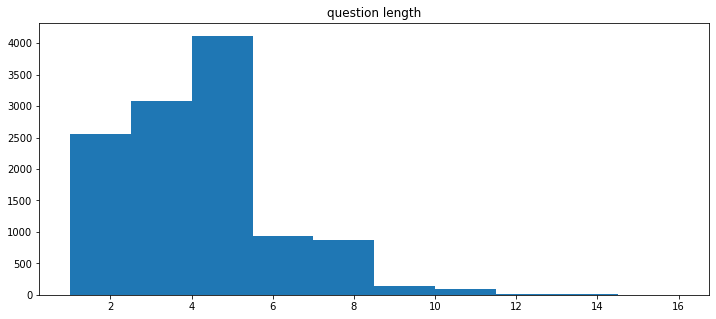

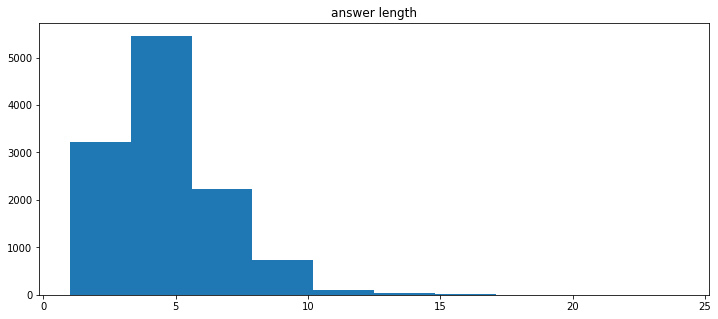

In [16]:
import matplotlib.pyplot as plt 

question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print(max(question_len))
print(max(answer_len))

plt.figure(figsize=(12, 5))
plt.hist(question_len)
plt.title('question length')

plt.figure(figsize=(12, 5))
plt.hist(answer_len)
plt.title('answer length')

In [17]:
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [18]:
#정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        #정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        #최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    #최대 길이 40으로 모든 데이터셋을 패딩    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')        

    return tokenized_inputs, tokenized_outputs

In [19]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장 크기:', (VOCAB_SIZE))
print('필터링 후 질문 샘플 개수:{}'.format(len(questions)))
print('필터링 후 답변 샘플 개수:{}'.format(len(answers)))

단어장 크기: 8129
필터링 후 질문 샘플 개수:11823
필터링 후 답변 샘플 개수:11823


<h3>교사 강요(Teacher Forcing)사용하기</h3>

질문과 답변의 쌍을 tf.Data.Dataset의 입력으로 넣어주는 작업  
이때, 디코더의 입력과 실제값(레이블)을 정의하기 위해 교사강요(Teacher Forcing) 사용  
-> 데이터를 모델에 공급하기 전에 전처리 및 배치 처리를 수행하는 것

In [20]:
BATCH_SIZE = 64 #모델을 한번에 처리할 샘플의 갯수
BUFFER_SIZE = 20000 #데이터를 섞을 때 사용하는 버퍼 크기

dataset = tf.data.Dataset.from_tensor_slices(( #함수를 사용하여 입력과 출력을 텐서로 변환
    {'inputs': questions, #질문
    'dec_inputs':answers[:, :-1]}, #답변의 일부분
    {'outputs': answers[:, 1:]}  # START_TOKEN 제외
))

dataset = dataset.cache() #데이터가 메모리나 로컬 스토리지에 캐시되어 재사용
dataset = dataset.shuffle(BUFFER_SIZE) #모델이 데이터셋의 순서에 의존하지 않도록 함
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) #병목현상 방지

<h2>03.Transformer모델 구현 및 학습</h2>

In [21]:
#포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):#각 위치에 대한 각도를 계산하는 메서드
        angles = 1/tf.pow(10000, (2* (i//2))/ tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                    i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                    d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2]) # 짝수 인덱스
        cosines = tf.math.cos(angle_rads[:, 1::2]) # 홀수 인덱스
        
        pos_encoding = tf.concat([sines, cosines], axis= -1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

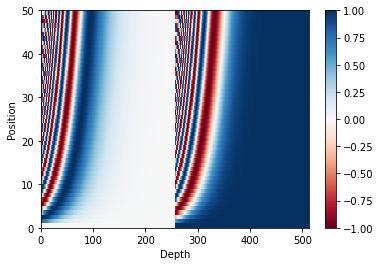

In [22]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

이 함수는 주어진 query, key, value를 사용하여 어텐션 가중치를 계산하고 이를 적용하여 최종 어텐션 값을 반환

In [23]:
#스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True) #Query와 Key간의 행렬곱셈
    
    #가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32) #Key의 dim
    logits = matmul_qk / tf.math.sqrt(depth) #제곱근을 적용하여 스케일 조정
    
    #패딩을 마스크 추가
    if mask is not None:
        logits += (mask * - 1e9)
    
    #softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    #최종 어텐션은 가중치와 v의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output

<h5>패딩을 마스크에 추가하는 이유</h5>  
모델의 학습 또는 추론 시에 패딩된 부분을 무시하기 위함  /
어텐션 연산의 안정성을 유지하기 위함

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0 #입력을 여러 헤드로 나눔
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        
        return outputs

In [25]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :] # [batch_size, 1, 1, sequence_length]

In [26]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [27]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [28]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [29]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [30]:
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
    #입력과 패딩 마스크를 받는 두 개의 입력을 정의
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    #MultiHeadAttention 레이어를 호출하여 Self-Attention을 수행
    attention = MultiHeadAttention(d_model, num_heads, name='attention')({
        'query':inputs, 'key':inputs, 'value':inputs, 'mask':padding_mask
    })
    
    #어텐션 결과에 드롭아웃과 레이어 정규화를 적용하여 인코더 레이어의 첫 번째 출력 생성
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    #Dense 레이어를 통해 출력의 차원을 조정
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    #다시 한 번 드롭 아웃과 레이어 정규화를 적용하고, 이를 이전의 어텐션 결과와 합하여 최종 출력을 생성
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    # 입력과 패딩 마스크를 받아서 Self-Attention을 수행하고, 그 결과를 활용하여 레이어를 통과시키는 방식으로 인코더 레이어를 구성
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [40]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='encoder'):
    # 입력과 패딩 마스크를 받는 두 개의 입력을 정의
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 입력을 임베딩하여 모델의 차원에 맞게 변환
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 위치 인코딩을 추가
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
                                
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
                                
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name='encoder_layer_{}'.format(i),)([outputs, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
                                
                                

In [41]:
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
    #네 개의 입력을 받는 디코더 레이어를 정의
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    #첫 번째 멀티 헤드 어텐션 : Self attentaion
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(inputs={
        'query':inputs, 'key':inputs, 'value':inputs, 'mask':look_ahead_mask
    })
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    #두 번째 멀티 헤드 어텐션: Encoder-Decoder Attention
    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(inputs={
        'query':attention1, 'key':enc_outputs, 'value':enc_outputs, 'mask':padding_mask
    })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    #포지션 와이즈 피드 포워드 신경망
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    #드롭아웃과 레이어 정규화를 적용
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [42]:
#디코더 구현
def decoder(vocab_size, num_layers, units, d_model,num_heads, dropout, name='decoder'):
    #네 개의 입력을 맏는 디코더 모델을 정의
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    #입력을 임베딩하고, 위치 인코딩을 추가
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [43]:
def transformer(vocab_size, num_layers,
               units, d_model, num_heads, dropout, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    # encoder에서 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    # decoder에서 미래 토큰 마스크, 패딩 마스크
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)
    # 두번째 어텐션 블록에서 encoder의 벡터들을 마스킹, decoder에서 패딩 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)
    
    # encoder
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask])
    # decoder
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # dense layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [44]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2  # encoder, decoder의 층 개수
D_MODEL = 256   # encoder, decoder 내부의 입/출력 고정 차원
NUM_HEADS = 8   # 멀티 헤드 어텐션의 헤드 수 
UNITS = 512     # feed forward 신경망 은닉층의 크기
DROPOUT = 0.1

model = transformer(vocab_size=VOCAB_SIZE, 
                   num_layers=NUM_LAYERS,
                   d_model=D_MODEL,
                   num_heads=NUM_HEADS,
                   units=UNITS,
                   dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3135232     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

<h2>04. 손실 함수(Loss function)</h2>

In [45]:
def loss_function(y_true, y_pred):
    #y_true를 모델의 예측 shape에 맞게 재구성
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))
    
    #Sparse Categorical Crossentropy를 사용하여 손실을 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    # 패딩이 아닌 부분에 대해서만 손실을 계산하도록 마스크를 적용
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

주의! 손실 함수는 트랜스포머 모델에서 사용되며, 패딩된 부분은 손실에 반영되지 않도록 한다

In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

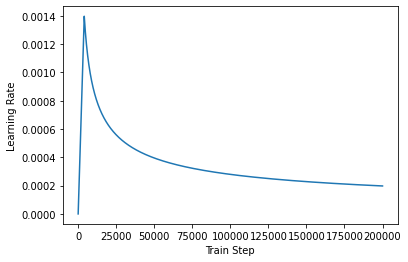

In [47]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [48]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [55]:
EPOCHS = 40
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
185/185 [==============================] - 10s 55ms/step - loss: 0.0429 - accuracy: 0.1648
Epoch 2/40
185/185 [==============================] - 10s 55ms/step - loss: 0.0411 - accuracy: 0.1649
Epoch 3/40
185/185 [==============================] - 10s 55ms/step - loss: 0.0373 - accuracy: 0.1657
Epoch 4/40
185/185 [==============================] - 10s 56ms/step - loss: 0.0319 - accuracy: 0.1671
Epoch 5/40
185/185 [==============================] - 10s 55ms/step - loss: 0.0283 - accuracy: 0.1680
Epoch 6/40
185/185 [==============================] - 10s 55ms/step - loss: 0.0255 - accuracy: 0.1685
Epoch 7/40
185/185 [==============================] - 10s 55ms/step - loss: 0.0227 - accuracy: 0.1692
Epoch 8/40
185/185 [==============================] - 10s 55ms/step - loss: 0.0208 - accuracy: 0.1698
Epoch 9/40
185/185 [==============================] - 10s 55ms/step - loss: 0.0189 - accuracy: 0.1702
Epoch 10/40
185/185 [==============================] - 10s 55ms/step - loss: 0.017

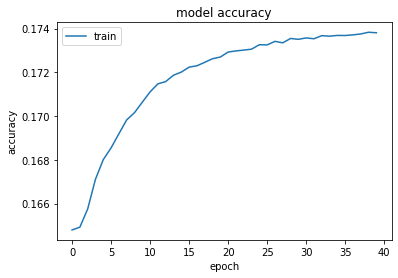

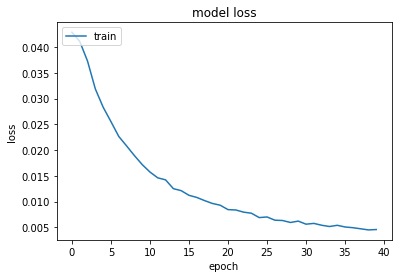

In [56]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

<h2>05.모델평가</h2>

In [57]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
    return tf.squeeze(output_sequence, axis=0)

In [58]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))    
    
    return predicted_sentence

In [64]:
sentence_generation('잠이 와')

입력 : 잠이 와
출력 : 일찍 주무세요 .


'일찍 주무세요 .'

In [60]:
sentence_generation('기분 좋아')

입력 : 기분 좋아
출력 : 저도 좋아요 .


'저도 좋아요 .'

In [61]:
sentence_generation('너무 추워')

입력 : 너무 추워
출력 : 따듯한 차 한잔 어때요 ?


'따듯한 차 한잔 어때요 ?'

In [62]:
sentence_generation('게임하고 싶다')

입력 : 게임하고 싶다
출력 : 게임하세요 !


'게임하세요 !'

In [63]:
sentence_generation('커피 한잔 할래?')

입력 : 커피 한잔 할래?
출력 : 한 잔 하기 좋은 날이네요 .


'한 잔 하기 좋은 날이네요 .'

<h3>회고</h3>

처음에 물어보는 말에 이상한 답변만해서 epoch를 조정하면서 적절한 수치를 찾았는데 너무 높게한다고 성능이 무조건 좋아지지는 않아서 적절하게 40으로 결정하였다.
그리고 chatgpt에 비하면 별로 못하지만 그래도 이렇게 챗봇을 직접 제작해보니 무언가 하나를 성취한 듯하여 기분은 좋다고 할 수 있다. 다만 아쉬운 점이 있다면 좀더 완벽하게 대답할 수 있는 챗봇을 만들고 싶었는데 그게 안되서 아쉬운 것 같고 앞으로 accuracy를 볼 때는 항상 그래프를 그리면서 보는게 훨씬 가독성이 있고 문제점을 찾기 쉽다는 것 또한 깨달았다. 수치만 보게되면 어디서 어떻게 잘못되었는지는 알기 쉽지 않기 때문이다. 이번 노드 내용이 이해가 되지 않기 때문에 좀더 인터넷에 찾아보고 알아봐야겠다